<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session_2.5_Assignment/assigment25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST dataset train and test

In [1]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
import torch.nn as nn

In [3]:
print ("Pytorch version:", torch.__version__)

Pytorch version: 1.13.0+cu116


Select GPU mode

In [4]:
# Check if GPU available
if torch.cuda.is_available():
  print ("On GPU")
else :
  print ("No GPU available")
     
device = 'cuda' if torch.cuda.is_available() else 'cpu'

On GPU


# Creating a custom dataset

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [6]:
mnist =  torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform = transforms.Compose([
          transforms.ToTensor()
    ])
)

### One value in dataset

In [7]:
train_loader = torch.utils.data.DataLoader(mnist, batch_size = 1, shuffle=True)

label: tensor(5)
Random number generated: tensor(0)
Addition(randnum+image): tensor(5)
Image:


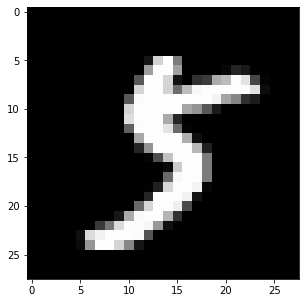

In [8]:
# creating custom dataset
class MyDataset(Dataset):
  def __init__(self):
    batch = next(iter(train_loader))
    self.data = batch[0]
    self.label = batch[1]

  def __getitem__(self, index):
    image = self.data[index]
    label = self.label[index]
    z = torch.tensor(random.randint(0, 9))
    #z_oh = one_hot (z)
    #return image, label, z_oh, label+z
    return image, label, z, label+z
   

  def __len__(self):
    return len(self.data)

myData = MyDataset()

for m in myData:
  print ("label:", m[1])
  print ("Random number generated:", m[2])
  print ("Addition(randnum+image):", m[3])
  print ("Image:")
  grid = torchvision.utils.make_grid(m[0], nrow=10)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

#print ("here", len(myData))

### Custom dataset

In [9]:
# one hot encoding
def one_hot (integer):
  rand_number = torch.zeros(28, 28)
  rand_number[:,] =1
  one_hot=torch.zeros(28)
  one_hot[integer]=1
  rand_number = rand_number * one_hot
  #print (rand_number)
  #print (rand_number.shape)
  rand_number = rand_number.unsqueeze(dim=0)
  return rand_number

In [10]:
def one_hot_label(label):
  rand_number = torch.zeros(1, 20)
  rand_number[:,] =1
  one_hot=torch.zeros(20)
  one_hot[label]=1
  rand_number = rand_number * one_hot
  #print (rand_number)
  rand_number = rand_number.squeeze(dim=0)
  return rand_number

In [11]:
class CustomDataset(Dataset):
  def __init__(self, batch_size = 50000):
    train_loader = torch.utils.data.DataLoader(mnist, batch_size = batch_size, shuffle=True)
    batch = next(iter(train_loader))
    self.data = batch[0]
    self.label = batch[1]

  def __getitem__(self, index):
    image = self.data[index]
    label = self.label[index]
    z = torch.tensor(random.randint(0, 9))
    z_oh = one_hot(z)
    #label_add = one_hot_label(label+z)
    #return image, label, z_oh, label_add
    return image, label, z_oh, label+z

  def __len__(self):
    return len(self.data)

'''
for m in data:
  print ("label:", m[1])
  print ("Random number generated:", m[2])
  print ("Addition(randnum+image):", m[3])
  print ("Image:")
  grid = torchvision.utils.make_grid(m[0], nrow=10)
  plt.figure(figsize=(2,2))
  plt.imshow(np.transpose(grid, (1,2,0)))
'''


'\nfor m in data:\n  print ("label:", m[1])\n  print ("Random number generated:", m[2])\n  print ("Addition(randnum+image):", m[3])\n  print ("Image:")\n  grid = torchvision.utils.make_grid(m[0], nrow=10)\n  plt.figure(figsize=(2,2))\n  plt.imshow(np.transpose(grid, (1,2,0)))\n'

# Model addition


In [12]:
import torch.nn.functional as F
import torch.optim as optim
class Flatten(nn.Module):
    def forward(self,x):
        N,_,_,_ = x.size()
        return x.view(N,-1)

In [13]:
import torch.nn.functional as F
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.bn1  = nn.BatchNorm2d(num_features=16)
        self.bn2   = nn.BatchNorm2d(num_features=32)
        self.bn3   = nn.BatchNorm2d(num_features=64)
        self.mp   = nn.MaxPool2d(kernel_size=2,stride=2)
        self.do   = nn.Dropout2d(p=0.5)
        self.l1   =  nn.Linear(128,1024)
        self.l2   =  nn.Linear(1024,19)

        self.l3 = nn.Linear(64, 1024)
        self.l4 = nn.Linear(1024, 10)
        
    def forward(self, x , y):
        x = self.conv_layers1(x)
        y = self.conv_layers1(y)
        x = self.conv_layers2(x)
        y = self.conv_layers2(y)
        x = self.conv_layers3(x)
        y = self.conv_layers3(y)
        N ,_,_,_ = x.size()
        x = x.view(N,-1)
        #print ("value_check:", N)
        y = y.view(N,-1)
        #z = self.conv_layers2(x + y)
        z = torch.cat((x,y),1)
        #z = z.view(N,-1)
        #print(z.size())
        z = self.l1(z)
        z = self.relu(z)
        z = self.l2(z)

        x = self.l3(x)
        x = self.relu(x)
        x = self.l4(x)
        return x, z
    
    def conv_layers1(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.mp(x)
        return x
    
    def conv_layers2(self, x):
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.mp(x)
        return x
    
    def conv_layers3(self, x):
        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.mp(x)
        return x

In [14]:
model = Model()
model.to(device)

Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do): Dropout2d(p=0.5, inplace=False)
  (l1): Linear(in_features=128, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=19, bias=True)
  (l3): Linear(in_features=64, out_features=1024, bias=True)
  (l4): Linear(in_features=1024, out_features=10, bias=True)
)

### Training

In [15]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [16]:
data = CustomDataset(len(mnist)) # 256 is the batch size
#print (len(data))
loader = torch.utils.data.DataLoader(data, batch_size=256)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
  total_loss_1 = 0
  total_correct_1 = 0
  total_loss_2 = 0
  total_correct_2 = 0
  for images, labels, rd, rl in loader: # Get Batch
      #print (images.size(), labels.size(), rd.size(), rl.size())
      images = images.to(device)
      labels = labels.to(device)
      rd = rd.to(device)
      rl = rl.to(device)

      preds1, preds2 = model(images, rd) # Pass Batch of images and one hot encoded random number

      loss1 = F.cross_entropy(preds1, labels) # Calculate Loss1
      loss2 = F.cross_entropy(preds2, rl) # Calculate Loss2

      optimizer.zero_grad()
      loss1.backward(retain_graph=True) # Calculate Gradients
      loss2.backward(retain_graph=True) # Calculate Gradients

      optimizer.step() # Update Weights

      total_loss_1 += loss1.item()
      total_correct_1 += get_num_correct(preds1, labels)

      total_loss_2 += loss2.item()
      total_correct_2 += get_num_correct(preds2, rl)

  print(
      "epoch:", epoch, "\n",
      "\tMNIST-LENET Architecture: { "
      #"total_correct:", total_correct/len(train_set)*100, 
      "accuracy(percentage):", total_correct_1/len(mnist)*100,
      #"loss:", total_loss/len(train_loader)
      "loss:", total_loss_1,"}\n"
      "\tAddition(MNIST+RAND_NO) Architecture: { "
      #"total_correct:", total_correct/len(train_set)*100, 
      "accuracy(percentage):", total_correct_2/len(mnist)*100,
      #"loss:", total_loss/len(train_loader)
      "loss:", total_loss_2,"}\n"
  )

epoch: 0 
 	MNIST-LENET Architecture: { accuracy(percentage): 95.14666666666668 loss: 37.67370465118438 }
	Addition(MNIST+RAND_NO) Architecture: { accuracy(percentage): 87.785 loss: 94.13048843294382 }

epoch: 1 
 	MNIST-LENET Architecture: { accuracy(percentage): 98.63 loss: 10.8749037864618 }
	Addition(MNIST+RAND_NO) Architecture: { accuracy(percentage): 98.09833333333333 loss: 16.405367070809007 }

epoch: 2 
 	MNIST-LENET Architecture: { accuracy(percentage): 98.91666666666666 loss: 8.377613559830934 }
	Addition(MNIST+RAND_NO) Architecture: { accuracy(percentage): 98.53166666666667 loss: 12.728949782904238 }

epoch: 3 
 	MNIST-LENET Architecture: { accuracy(percentage): 99.19 loss: 6.396785899414681 }
	Addition(MNIST+RAND_NO) Architecture: { accuracy(percentage): 98.82333333333332 loss: 9.882947911974043 }

epoch: 4 
 	MNIST-LENET Architecture: { accuracy(percentage): 99.31833333333333 loss: 5.178995206253603 }
	Addition(MNIST+RAND_NO) Architecture: { accuracy(percentage): 99.024999